In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import tensorflow.keras.layers as ly
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
train_b = False

In [ ]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RRMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])**2 for i in range(n)]
    n = [float(y_test[i])**2 for i in range(n)]
    return np.sqrt(sum(rmse_list)/sum(n))    
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [ ]:
data = []
#for y in range(2017,2023):
for y in [2021]:
  df = pd.read_csv(f"{DATA_DIR}/Total_Data_{y}_5m.csv")
  data.append(df)
data = pd.concat(data)
print(data.head(20).to_string())

             Unnamed: 0     CAPITL     CENTRL    DUNWOD     GENESE     HUD VL     LONGIL    MHK VL    MILLWD     N.Y.C.     NORTH       WEST        NYCA  Global Horizontal UV Irradiance (280-400nm)  Global Horizontal UV Irradiance (295-385nm)  HourlyDryBulbTemperature  HourlyRelativeHumidity
0   2021-01-01 00:00:00  1253.6528  1646.5823  602.6414  1009.6906  1031.5640  2128.3490  861.0112  344.1649  4915.3086  643.6438  1574.9854  16011.5940                                          0.0                                          0.0                 34.700000               64.900000
1   2021-01-01 00:05:00  1261.2753  1675.9110  602.1752   999.1802  1021.9031  2126.8270  849.0410  344.4898  4892.8174  644.0825  1568.2175  15985.9200                                          0.0                                          0.0                 34.533333               65.400000
2   2021-01-01 00:10:00  1238.2727  1660.6127  608.2949   997.9413  1014.6226  2089.7195  849.0281  336.7801  4868.1533  

In [ ]:
future_var = ['Global Horizontal UV Irradiance (280-400nm)','HourlyDryBulbTemperature','HourlyRelativeHumidity']
for c in future_var:
  data[c+" Future"] = data[c].shift(-forecast_window).backfill()

used_var = ['N.Y.C.','Global Horizontal UV Irradiance (280-400nm)','HourlyDryBulbTemperature','HourlyRelativeHumidity','Global Horizontal UV Irradiance (280-400nm) Future','HourlyDryBulbTemperature Future','HourlyRelativeHumidity Future']
data = data[used_var].backfill();
data = data.dropna(how='any')

for c in used_var:
  #print(data[c].head(15));
  print(c,len(data[c].index),data[c].mean(),data[c].std())

print(data.head(5).to_string())
n = len(data.index)
t = int(7*24*(60/5))
num_var = len(used_var)

N.Y.C. 105102 5574.236639466899 1157.7346584901197
Global Horizontal UV Irradiance (280-400nm) 105102 9.306859028372438 14.709639920529495
HourlyDryBulbTemperature 105102 56.03220750925196 16.508206768495132
HourlyRelativeHumidity 105102 67.15346660862359 19.60431334497092
Global Horizontal UV Irradiance (280-400nm) Future 105102 9.306859028372438 14.709639920529495
HourlyDryBulbTemperature Future 105102 56.03478681325037 16.505866228760585
HourlyRelativeHumidity Future 105102 67.15854537779073 19.60851278565285
      N.Y.C.  Global Horizontal UV Irradiance (280-400nm)  HourlyDryBulbTemperature  HourlyRelativeHumidity  Global Horizontal UV Irradiance (280-400nm) Future  HourlyDryBulbTemperature Future  HourlyRelativeHumidity Future
0  4915.3086                                          0.0                 34.700000                    64.9                                                 0.0                             33.0                      71.176471
1  4892.8174                      

In [ ]:
data

,N.Y.C.,Global Horizontal UV Irradiance (280-400nm),HourlyDryBulbTemperature,HourlyRelativeHumidity,Global Horizontal UV Irradiance (280-400nm) Future,HourlyDryBulbTemperature Future,HourlyRelativeHumidity Future
0,4915.3086,0.0,34.700000,64.9000,0.0,33.000000,71.176471
1,4892.8174,0.0,34.533333,65.4000,0.0,33.000000,71.372549
2,4868.1533,0.0,34.366667,65.9000,0.0,33.000000,71.568627
3,4856.5923,0.0,34.200000,66.4000,0.0,33.000000,71.764706
4,4829.3720,0.0,34.033333,66.9000,0.0,33.000000,71.960784
...,...,...,...,...,...,...,...
105097,4999.0645,0.0,48.687500,97.9375,0.0,49.000000,97.000000
105098,4970.3545,0.0,48.375000,98.8750,0.0,49.000000,97.000000
105099,4971.9966,0.0,48.062500,99.8125,0.0,49.000000,97.000000
105100,4916.0596,0.0,48.000000,100.0000,0.0,49.000000,97.000000


In [ ]:
m = 5574.113154123897;std = 1157.6820234795014
m_s = 9.305353909378894 ;std_s = 14.708926535057076
m_t = 56.030910041113;std_t = 16.507268780702415
m_h = 67.15854537779073;std_h = 19.60851278565285

m_list = [m,m_s,m_t,m_h,m_s,m_t,m_h]
std_list = [std,std_s,std_t,std_h,std_s,std_t,std_h]

def untransform_dataset_old(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    dataset=dataset.reshape(nv,ns*tw)
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=3):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[0]-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].T
    dataX.append(a)
    
    e = dataset[i + hist_window:  i + hist_window+forecast_window, 0]
    dataY.append(e)
  return np.array(dataX), np.array(dataY)

def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==2:
    #ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    ns,nv = s
    dataset=dataset.T 
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.T 
  else:
    dataset=(dataset-mi[0])/stdi[0] 
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  dataset=(dataset*stdi[0])+mi[0]
  return dataset  
dataset = data[used_var].values
dataset_xfr = transform_dataset(dataset)

x,y = create_dataset_mult(dataset_xfr,hist_window,forecast_window,num_var)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

In [ ]:
# reshape input to be [samples, time steps, features]
#print(train.shape)
#train = np.reshape(train, (train.shape[0], num_var, train.shape[1]))
#valid = np.reshape(valid, (valid.shape[0], num_var, valid.shape[1]))

#Build Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               47600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 18)                1818      
                                                                 
Total params: 49,418
Trainable params: 49,418
Non-trainable params: 0
_________________________________________________________________


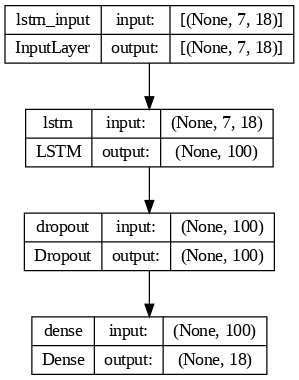

In [ ]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Test"
def create_LSTM_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005,var_num = 2,
                      hist_window=18,forecast_window=18):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(var_num,hist_window)))
    model.add(Dropout(.1))
    model.add(Dense(forecast_window))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model(LSTM_i=100, var_num=num_var)
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [ ]:
#Fit Model
model_name = 'test_model_slope_with_solar_weather_future_100_humidity.h5'
print(datetime.datetime.now())
if train_b:
  model.fit(train, label_t, epochs=5, batch_size=1, verbose=2)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-03-01 00:23:29.852969


62/62 [==============================] - 3s 12ms/step
Total Test Score: 272.47 RMSE
90 Min Test Score: 92.76 RMSE
Relative Test Score: 1.82 perc RMSE


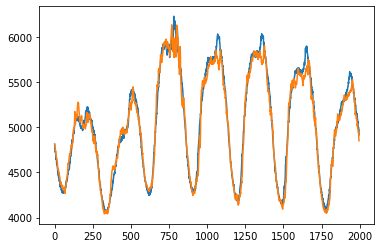

In [ ]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict(valid)

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()

# Load prediction with weather correction

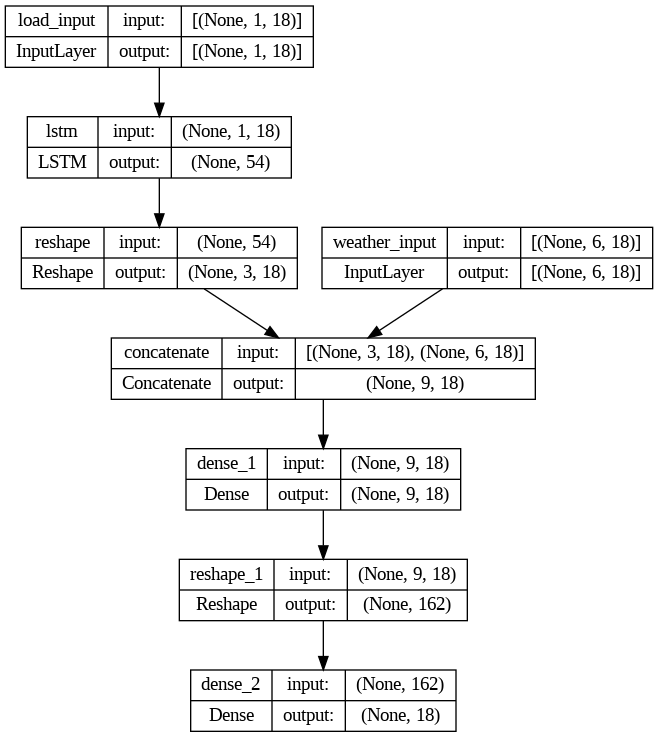

In [ ]:
def create_multi_input_model(recurrent_dropout=0.05,lstm_multiple = 3,
                      learning_rate=0.00005,var_num = 6,
                      hist_window=18,forecast_window=18):
  
  load_input = ly.Input(shape=(1,hist_window), name='load_input')
  weather =  ly.Input(shape=(var_num,hist_window), name='weather_input')
  lstm = ly.LSTM(lstm_multiple * hist_window,  recurrent_dropout=recurrent_dropout, name = 'lstm')(load_input)
  lstm = ly.Reshape((lstm_multiple, hist_window))(lstm)
  all_input = ly.Concatenate(axis=1)([lstm, weather])
  forcast = ly.Dense(forecast_window)(all_input)
  forcast = ly.Reshape(((var_num+lstm_multiple)*hist_window,))(forcast) # can use a convolution layer here? 
  forcast = ly.Dense(forecast_window)(forcast)

  model = Model(inputs = [load_input, weather], outputs = [forcast])

  return model
model = create_multi_input_model() 
plot_model (model, show_shapes=True)

In [ ]:
# def model_train(model, load_input, weather_input, load_target):
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Test"
model_name = 'test_LSTM_mulyi_input_hum.h5'

# model = create_multi_input_model()
model.compile(loss='mean_squared_error', optimizer='adam')

if train_b:
  model_hist = model.fit([train[:,0:1,:], train[:,1:,:]], label_t, epochs=5)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

Epoch 1/5
3222/3222 [==============================] - 32s 8ms/step - loss: 0.0264
Epoch 2/5
3222/3222 [==============================] - 18s 6ms/step - loss: 0.0064
Epoch 3/5
3222/3222 [==============================] - 18s 6ms/step - loss: 0.0057
Epoch 4/5
3222/3222 [==============================] - 20s 6ms/step - loss: 0.0056
Epoch 5/5
3222/3222 [==============================] - 24s 7ms/step - loss: 0.0055


In [ ]:
label_t

array([[-0.81706128, -0.82611644, -0.8323508 , ..., -0.98186128,
        -0.98890691, -0.98899018],
       [-0.82611644, -0.8323508 , -0.83693807, ..., -0.98890691,
        -0.98899018, -0.99038987],
       [-0.8323508 , -0.83693807, -0.86622072, ..., -0.98899018,
        -0.99038987, -1.00792716],
       ...,
       [-0.6331562 , -0.62958968, -0.63598712, ..., -0.80613747,
        -0.8437249 , -0.83035077],
       [-0.62958968, -0.63598712, -0.65844285, ..., -0.8437249 ,
        -0.83035077, -0.85820902],
       [-0.63598712, -0.65844285, -0.70260671, ..., -0.83035077,
        -0.85820902, -0.85805207]])

In [ ]:
pred = model.predict([train[:,0:1,:], train[:,1:,:]])
pred

3222/3222 [==============================] - 10s 3ms/step


array([[-0.8349729 , -0.84850425, -0.8550838 , ..., -0.99557394,
        -0.99960595, -1.0100133 ],
       [-0.8456219 , -0.8560656 , -0.8673109 , ..., -0.9915504 ,
        -0.9954739 , -1.0034653 ],
       [-0.85344046, -0.8624303 , -0.8723241 , ..., -0.9890209 ,
        -0.99436444, -1.0021255 ],
       ...,
       [-0.6298608 , -0.6441422 , -0.65930915, ..., -0.8358367 ,
        -0.84255487, -0.8531237 ],
       [-0.6514754 , -0.66539097, -0.67703986, ..., -0.87006956,
        -0.88345903, -0.89452684],
       [-0.666086  , -0.67826897, -0.68697655, ..., -0.8695514 ,
        -0.8783465 , -0.8923098 ]], dtype=float32)

62/62 [==============================] - 0s 4ms/step
Total Test Score: 324.15 RMSE
90 Min Test Score: 121.91 RMSE
Relative Test Score: 2.40 perc RMSE


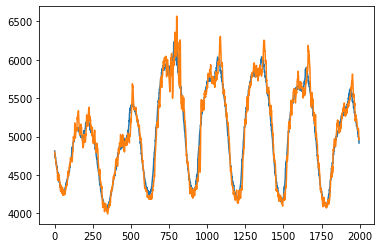

In [ ]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict([valid[:,0:1,:], valid[:,1:,:]])

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Total Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('90 Min Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))
print('Relative Test Score: %.2f perc RMSE' % (100*RRMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()